In [1]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def generate_random_price_series(start_date='2023-01-01', periods=252, start_price=100, volatility=0.01):
    """
    Generate a random price series over a year.
    
    Parameters:
    - start_date (str): The start date for the series in 'YYYY-MM-DD' format.
    - periods (int): Number of trading days (default is 252, typical number of trading days in a year).
    - start_price (float): The initial price.
    - volatility (float): Daily volatility (standard deviation of daily returns).
    
    Returns:
    - pd.Series: A pandas Series with datetime index and random price values.
    """
    # Generate date range
    date_range = pd.date_range(start=start_date, periods=periods, freq='B')
    
    # Generate random returns
    returns = np.random.normal(loc=0, scale=volatility, size=periods)
    
    # Calculate price series
    prices = start_price * (1 + returns).cumprod()
    
    # Create and return the pandas Series
    return pd.Series(prices, index=date_range, name='Price')

#### 1. Sampling for reduction
What conditions should preceed the algorithms training data

In [4]:
# 1. CUMSUM filter - when a cumulative price movement has taken place
# 2. Tight volatility range - consolidation period leads to bigger move
def inverse_cumsum_filter(series: pd.Series, h: float, n: int) -> pd.Series:
    """
    Apply a cumulative sum filter to a time series based on a rolling period.
    
    Parameters:
    - series: pd.Series, time series of prices with time stamp index
    - h: float, threshold value for filtering
    - n: int, lookback period for the rolling window
    
    Returns:
    - pd.Series, boolean series where True indicates dates flagged by the filter
    """
    returns = series.pct_change()       
    # Ensure the series is sorted by index (time)
    returns = returns.add(1)
    
    # Calculate the rolling cumulative sum over the lookback period n
    rolling_cumsum = returns.rolling(window=n).apply(np.prod) -1
    
    # Flag dates where the cumulative return is less than the absolute value of h
    flagged = (rolling_cumsum.abs() < h)
    
    return flagged

def plot_with_flags(series: pd.Series, flagged: pd.Series):
    """
    Plots a time series and highlights flagged dates as red dots.
    
    Parameters:
    - series: pd.Series, the original time series of returns with timestamp index
    - flagged: pd.Series, boolean series indicating flagged dates
    """
    # Ensure the series is sorted by time index
    series = series.sort_index()

    # Plot the time series
    plt.figure(figsize=(10, 6))
    plt.plot(series.index, series.values, label='Time Series', color='blue')

    # Highlight flagged dates as red dots
    plt.scatter(series.index[flagged], series.values[flagged], color='red', label='Flagged Dates')

    # Add labels and legend
    plt.title(f"Time Series with Flagged Dates; Percent labels = {np.average(flagged)*100}%")
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()


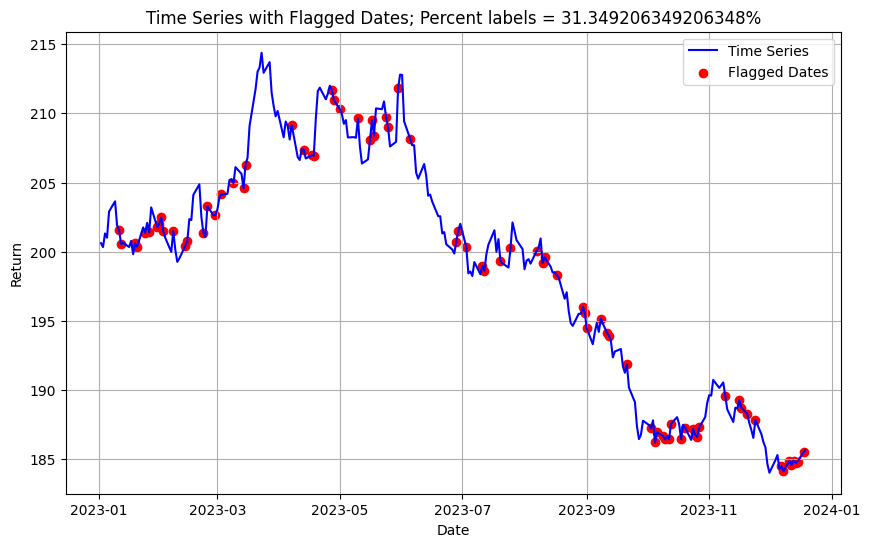

In [23]:
# Apply the cumsum_filter with a threshold h and a lookback period n
cumulative = generate_random_price_series()

h = 0.01
n = 5
flagged_dates = inverse_cumsum_filter(cumulative, h, n)
# percent_labels = np.average(flagged_dates)*100

plot_with_flags(series = cumulative+100, flagged = flagged_dates)

In [24]:
def generate_percent_label_matrix(samples: int = 100):
    """
    Generate a matrix of % label values for different combinations of h and n.
    
    h ranges from 0.01 to 0.2 with a step of 0.01.
    n ranges from 3 to 30 with a step of 1.
    The % label is based on an average of 100 random series.
    
    Returns:
    - pd.DataFrame, with rows as n values and columns as h values, containing % label values.
    """
    # Range of h values from 0.01 to 0.2 with step 0.01
    h_values = np.arange(0.01, 0.11, 0.01)
    # Range of n values from 3 to 30 with step 1
    n_values = np.arange(3, 31, 1)
    
    # Initialize an empty matrix to store % label values
    percent_label_matrix = np.zeros((len(n_values), len(h_values)))

    # Perform calculations
    for i, n in enumerate(n_values):
        for j, h in enumerate(h_values):
            # Average percent labels over 100 random series
            percent_labels = []
            for _ in range(samples):  # Generate 100 random series
                cumulative = generate_random_price_series()  # Generate random return series
                flagged_dates = inverse_cumsum_filter(cumulative, h, n)  # Apply filter
                percent_labels.append(np.average(flagged_dates) * 100)  # Calculate % flagged
            
            # Store the average % label in the matrix
            percent_label_matrix[i, j] = np.mean(percent_labels)
    
    # Convert the matrix into a DataFrame for better readability, with n as index and h as columns
    percent_label_df = pd.DataFrame(percent_label_matrix, index=n_values, columns=h_values)
    
    return percent_label_df

def plot_percent_label_matrix(matrix: pd.DataFrame, lower_threshold: float = 18, upper_threshold: float = 62):
    """
    Visualize the percent label matrix using a heatmap.
    
    Parameters:
    - matrix: pd.DataFrame, matrix of % label values where rows are n values and columns are h values
    """
    # Create a mask for values less than the threshold
    mask = (matrix < lower_threshold) | (matrix > upper_threshold)
    
    # Create the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix, mask=mask, annot=True, cmap="YlGnBu", cbar_kws={'label': '% Label'}, 
                vmin=lower_threshold, linewidths=0.5, linecolor='gray')
    
    # Set the labels and title
    plt.title('Heatmap of % Label Values for Different n and h')
    plt.xlabel('h (Threshold)')
    plt.ylabel('n (Lookback Period)')
    
    # Show the plot
    plt.show()

In [25]:
# Assuming percent_label_matrix is the output from generate_percent_label_matrix()
percent_label_matrix = generate_percent_label_matrix(100)

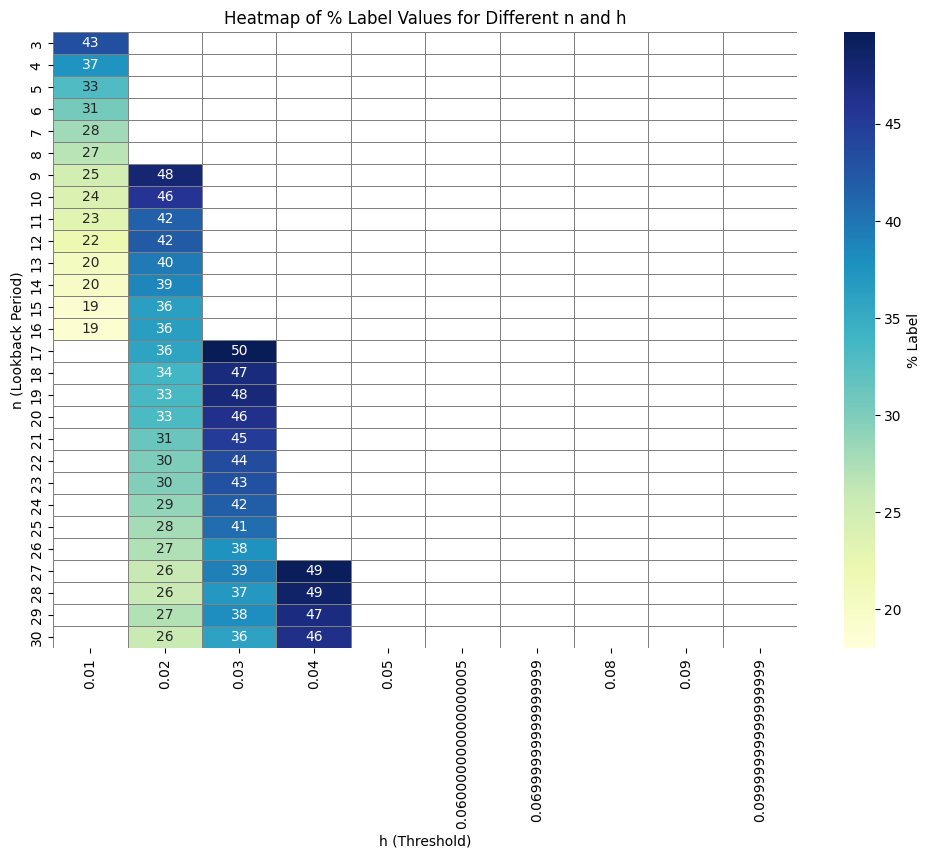

In [26]:
# Visualize the matrix
plot_percent_label_matrix(percent_label_matrix, upper_threshold=50)


#### 2. Triple barrier method

Vertical barrier: 3x-4x of inverse cumsum lookback period
Upper/lower barrier: 3x to 4x of inverse cumsum threshold

In [27]:
close = generate_random_price_series()

In [44]:
# Getting dates for the vertical barrier
def get_vertical_barrier(t_events, close, num_days=1):
    """Get a datetime index of dates for the vertical barrier

    Args:
        tEvents (datetime index): dates when the algorithm should look for trades
        close (pd.Series): series of prices
        numDays (int, optional): vertical barrier limit. Defaults to 1.

    Returns:
        pd.Series: series of datetime values
    """
    t1=close.index.searchsorted(t_events+pd.Timedelta(days=num_days))
    t1=t1[t1<close.shape[0]]
    t1=(pd.Series(close.index[t1],index=t_events[:t1.shape[0]]))
    return t1

In [ ]:
trgt = close.pct_change().dropna().ewm(span=20, adjust=False).std()
minRet = 0.02
ptSl = 2 # width of horizontal barriers (ptSl * trgt)

In [34]:
def applyPtSlOnT1(close,events,ptSl):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    out=events[['t1']].copy(deep=True)
    if ptSl[0]>0: pt=ptSl[0]*events['trgt']
    else: pt=pd.Series(index=events.index) # NaNs
    if ptSl[1]>0: sl=-ptSl[1]*events['trgt']
    else: sl=pd.Series(index=events.index) # NaNs
    for loc,t1 in events['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events.at[loc, 'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
    return out

def getEvents(close, tEvents, ptSl, trgt, minRet, t1=False, side=None):
    #1) get target
    trgt=trgt.loc[tEvents]
    trgt=trgt[trgt>minRet] # minRet

    #2) get t1 (max holding period)
    if t1 is False:
        t1=pd.Series(pd.NaT, index=tEvents)

    #3) form events object, apply stop loss on t1
    if side is None:
        side_,ptSl_=pd.Series(1.,index=trgt.index), [ptSl,ptSl]
    else: 
        side_,ptSl_=side.loc[trgt.index],ptSl[:2]

    events=(pd.concat({'t1':t1,'trgt':trgt,'side':side_}, axis=1).dropna(subset=['trgt']))
    df0 = applyPtSlOnT1(close=close, events=events, ptSl=ptSl_)

    #4) Get min date for each event
    events['t1']=df0.dropna(how='all').min(axis=1) #pd.min ignores nan

    if side is None:
        events=events.drop('side',axis=1)
        
    return events

In [69]:
t_events = inverse_cumsum_filter(close, h=0.01, n=5)
t_events = t_events[t_events].index

trgt = pd.Series(0.01, index=t_events)

v_bars = get_vertical_barrier(t_events, close, 20)
side = pd.Series(1., index=t_events)

pt_sl = [4, 4]

events = pd.concat({'vb':v_bars, 'trgt': trgt, 'side':side}, axis=1).dropna(subset=['trgt'])

exits = events[['vb']].copy(deep=True)

pt = pt_sl[0]*events['trgt']
sl = pt_sl[1]*events['trgt']

for event, vb in events['vb'].fillna(close.index[-1]).items():

    price_path = close[event:vb]
    return_path = (price_path/close[event]-1)*events.at[event, 'side']
    exits.loc[event,'sl'] = return_path[return_path<sl[event]].index.min() # earliest stop loss
    exits.loc[event,'pt'] = return_path[return_path>pt[event]].index.min() # earliest profit taking

    print(event)
    print(vb)
    break

2023-01-16 00:00:00
2023-02-06 00:00:00


In [68]:
events['vb']

2023-01-16   2023-02-06
2023-01-23   2023-02-13
2023-01-24   2023-02-13
2023-01-26   2023-02-15
2023-01-31   2023-02-20
                ...    
2023-11-21   2023-12-11
2023-11-23   2023-12-13
2023-11-27   2023-12-18
2023-11-29   2023-12-19
2023-12-07          NaT
Name: vb, Length: 81, dtype: datetime64[ns]